In [5]:
import numpy as np
import networkx as nx
import sys 
import pickle
from tqdm import tqdm
import time

sys.path.append('../src/')

%load_ext autoreload
%autoreload 2

from utils import *
from interpolating_prior import interpolated_prior
from angular_stress_heuristic import *
from greedy_topology_optimization import monte_carlo_step
from iterative_geometry_solver import iterative_geometry_solver

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'fast_geometry_optimizer'

12

 al= 1e-05
final result, after 712 iterations.


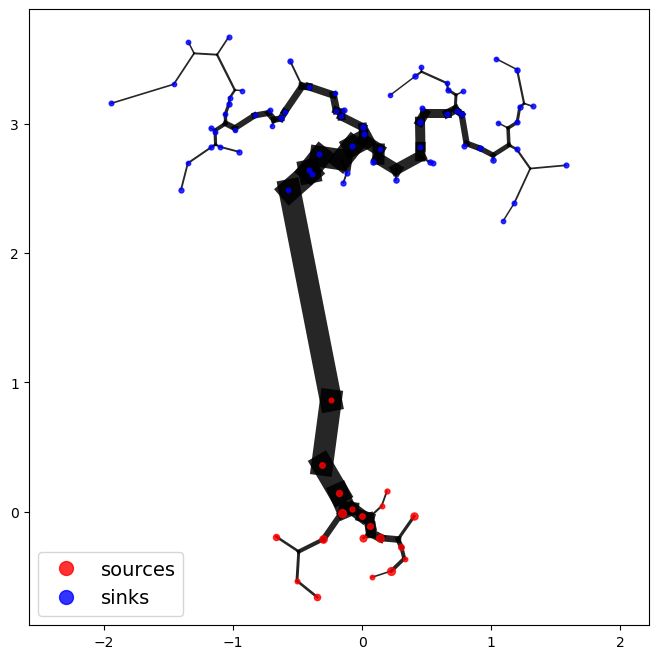

cost= 15.923964654312552

 al= 0.5
final result, after 1129 iterations.


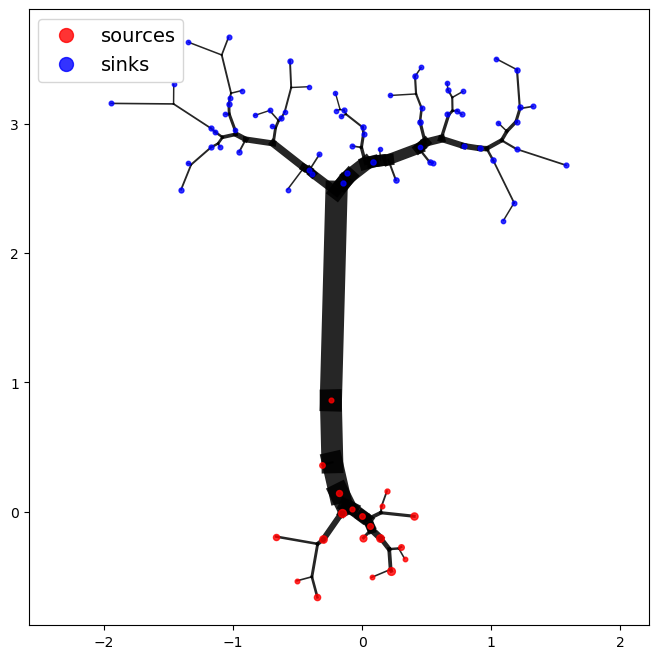

cost= 6.2553321766602945

 al= 0.95
final result, after 608 iterations.


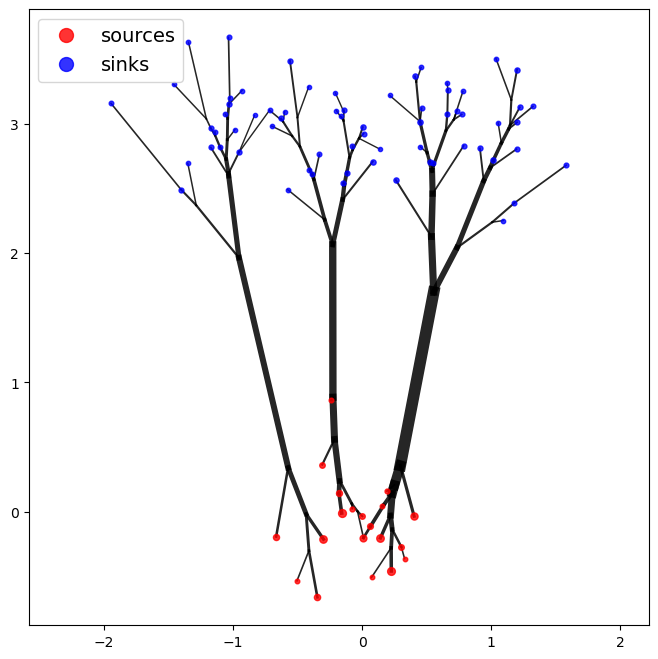

cost= 3.529032086002044

 al= 1.0


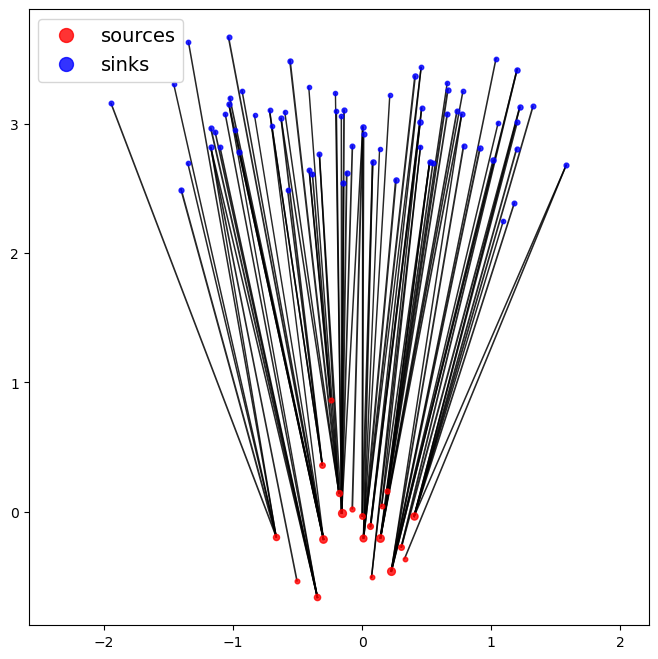

In [2]:
seed_list = [12]

for seed in seed_list:

    np.random.seed(seed)
    print(seed)

    #tree like experiment:
    n_sources = 20
    n_sinks = 45
    centers = np.array([
        [0,0],
        [-1,3],
        [0,3],
        [1,3]
    ])    

    coords_sources = np.random.normal(size=(n_sources, 2), scale=0.3) + centers[0]
    coords_sinks = np.vstack((np.random.normal(size=(int(n_sinks/2), 2), scale=0.3) + centers[1], 
                              np.random.normal(size=(int(n_sinks/2), 2), scale=0.3) + centers[2], 
                              np.random.normal(size=(int(n_sinks/2), 2), scale=0.3) + centers[3]))

    al_arr = np.array([0.00001, 0.5, 0.95, 1])

    bot_problem_dict = {}
    bot_problem_dict["coords_sources"] = coords_sources
    bot_problem_dict["coords_sinks"] = coords_sinks
    bot_problem_dict["supply_arr"] = np.random.random(len(coords_sources))
    bot_problem_dict["supply_arr"] /= np.sum(bot_problem_dict["supply_arr"])
    bot_problem_dict["demand_arr"] = np.random.random(len(coords_sinks))
    bot_problem_dict["demand_arr"] /= np.sum(bot_problem_dict["demand_arr"])

    supply_arr = bot_problem_dict["supply_arr"]
    demand_arr = bot_problem_dict["demand_arr"]

    for i,al in enumerate(al_arr):
        np.random.seed(seed_list[i])
        
        print("\n al=", al)
        bot_problem_dict["al"] = al    

        if al > 0.999:
            al = 1
            int_prior_topo = interpolated_prior(bot_problem_dict, beta = 1-al)
            cost, coords_real = iterative_bot_solver(int_prior_topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                                         relative_improvement_threshold=1e-6, min_iterations=-1, max_iterations=1000,
                                                         plot=False, title="", fov=None, save=False, save_name="img")

            coords_arr = np.vstack((coords_sources, coords_sinks))
            num_bps = nx.number_of_nodes(int_prior_topo) - len(supply_arr) -len(demand_arr)
            coords_arr = np.vstack((coords_arr, np.zeros((num_bps, 2)) ))
            for bp in int_prior_topo.nodes():
                if bp >= 0:
                    continue
                for neighbour in nx.neighbors(int_prior_topo, bp):
                    if neighbour >= 0:
                        coords_arr[bp] = np.copy(coords_arr[neighbour])

            visualise_BOT_solution(int_prior_topo, coords_arr, supply_arr, demand_arr, title="", fov=None, save=False, save_name=f"img1.0")

        else:
            beta = 1 - al
            int_prior_topo = interpolated_prior(bot_problem_dict, beta)
            stress_cost, stress_topo = angular_stress_reduction(int_prior_topo, bot_problem_dict, plot_final=False, plot=False)

            # stress heuristic with MC continued:
            topo = stress_topo.copy()
            cost, coords_iter = iterative_bot_solver(topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                                     relative_improvement_threshold=1e-9, min_iterations=-1,
                                                     max_iterations=10000,
                                                     plot=False, title="", fov=None, save=False, save_name="img")
            keep_going = True
            iteration = 0
            T = 0
            sample_edge_list = list(topo.edges())
            while keep_going and iteration < 60000:
                iteration += 1
                topo, sample_edge_list, cost, coords_iter, accepted = monte_carlo_step(topo, sample_edge_list, cost,
                                                                                       coords_iter, bot_problem_dict,
                                                                                       temperature=T)
                # check if converged:
                if len(sample_edge_list) == 0:
                    # this means that we have stuck with one topology for an entire run through.
                    keep_going = False

            print(f"final result, after {iteration} iterations.")

            cost, coords_iter = iterative_bot_solver(topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                                     relative_improvement_threshold=1e-7, min_iterations=-1,
                                                     max_iterations=2000,
                                                     plot=True, title="", fov=None, save=False, save_name=f"img{np.round(al,2)}")
            
            print("cost=", cost)